# Supply Chain KPI Analysis Dashboard

This notebook provides comprehensive analysis of key supply chain performance indicators including:
- Inventory turnover and management
- Order fulfillment metrics
- Supplier performance
- Cost analysis
- Demand forecasting accuracy

## 1. Import Libraries and Setup

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Data Loading and Preprocessing

In [13]:
# Semiconductor Manufacturing Supply Chain Data Generation
# This creates realistic data for a semiconductor manufacturing company

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
date_range = pd.date_range(start='2022-01-01', end='2024-12-31', freq='D')

# Define part families with realistic characteristics for semiconductor manufacturing
part_families = {
    'Machined_Parts': {
        'base_cost': (50, 500), 'base_lead_time': (14, 28), 'complexity_multiplier': 1.5,
        'suppliers': ['SUP_MACH_001', 'SUP_MACH_002', 'SUP_MACH_003', 'SUP_MACH_004']
    },
    'Sheet_Metal': {
        'base_cost': (25, 200), 'base_lead_time': (7, 21), 'complexity_multiplier': 1.2,
        'suppliers': ['SUP_SHEET_001', 'SUP_SHEET_002', 'SUP_SHEET_003']
    },
    'Electronics_Components': {
        'base_cost': (1, 100), 'base_lead_time': (21, 56), 'complexity_multiplier': 2.0,
        'suppliers': ['SUP_ELEC_001', 'SUP_ELEC_002', 'SUP_ELEC_003', 'SUP_ELEC_004', 'SUP_ELEC_005']
    },
    'Cables': {
        'base_cost': (10, 150), 'base_lead_time': (14, 35), 'complexity_multiplier': 1.3,
        'suppliers': ['SUP_CABLE_001', 'SUP_CABLE_002', 'SUP_CABLE_003']
    },
    'Castings': {
        'base_cost': (75, 800), 'base_lead_time': (28, 70), 'complexity_multiplier': 1.8,
        'suppliers': ['SUP_CAST_001', 'SUP_CAST_002']
    },
    'Forgings': {
        'base_cost': (100, 1000), 'base_lead_time': (35, 84), 'complexity_multiplier': 2.2,
        'suppliers': ['SUP_FORG_001', 'SUP_FORG_002']
    },
    'Lights': {
        'base_cost': (20, 300), 'base_lead_time': (14, 42), 'complexity_multiplier': 1.4,
        'suppliers': ['SUP_LIGHT_001', 'SUP_LIGHT_002', 'SUP_LIGHT_003']
    },
    'Assembled_Kits': {
        'base_cost': (200, 5000), 'base_lead_time': (42, 120), 'complexity_multiplier': 3.0,
        'suppliers': ['SUP_ASSY_001', 'SUP_ASSY_002', 'SUP_ASSY_003']
    },
    'Consumables': {
        'base_cost': (0.1, 50), 'base_lead_time': (3, 14), 'complexity_multiplier': 1.0,
        'suppliers': ['SUP_CONS_001', 'SUP_CONS_002', 'SUP_CONS_003', 'SUP_CONS_004']
    }
}

# External factors that affect lead times
external_factors = {
    'COVID_19': {'start': '2020-03-01', 'end': '2021-12-31', 'lt_multiplier': 2.5, 'probability': 0.8},
    'Chinese_New_Year': {'months': [1, 2], 'lt_multiplier': 1.5, 'probability': 0.6},
    'Weather_Disruption': {'months': [11, 12, 1, 2], 'lt_multiplier': 1.3, 'probability': 0.2},
    'Tariff_Impact': {'start': '2023-01-01', 'end': '2024-06-30', 'lt_multiplier': 1.4, 'probability': 0.3},
    'Semiconductor_Shortage': {'start': '2021-01-01', 'end': '2023-12-31', 'lt_multiplier': 2.0, 'probability': 0.7},
    'Thanksgiving_Week': {'weeks': [47], 'lt_multiplier': 1.2, 'probability': 0.4},
    'Christmas_Shutdown': {'weeks': [51, 52], 'lt_multiplier': 1.8, 'probability': 0.9}
}

# Generate all suppliers
all_suppliers = []
for family_data in part_families.values():
    all_suppliers.extend(family_data['suppliers'])
all_suppliers = list(set(all_suppliers))

# Generate parts catalog
parts_catalog = []
part_id = 1
for family, family_data in part_families.items():
    n_parts = {'Consumables': 200, 'Electronics_Components': 150}.get(family, 50)
    
    for i in range(n_parts):
        complexity = np.random.choice(['Low', 'Medium', 'High'], p=[0.4, 0.4, 0.2])
        complexity_mult = {'Low': 1.0, 'Medium': 1.5, 'High': 2.0}[complexity]
        
        base_cost_range = family_data['base_cost']
        base_lt_range = family_data['base_lead_time']
        
        unit_cost = np.random.uniform(*base_cost_range) * complexity_mult
        nominal_lead_time = int(np.random.uniform(*base_lt_range) * complexity_mult)
        
        # MOQ based on part type and cost
        if family == 'Consumables':
            moq = np.random.choice([100, 250, 500, 1000, 2500])
        elif family == 'Electronics_Components':
            moq = np.random.choice([10, 25, 50, 100, 250])
        else:
            moq = np.random.choice([1, 5, 10, 25, 50])
        
        parts_catalog.append({
            'part_number': f'{family[:4].upper()}_{part_id:04d}',
            'part_family': family,
            'complexity': complexity,
            'unit_cost': round(unit_cost, 2),
            'nominal_lead_time_days': nominal_lead_time,
            'moq': moq,
            'preferred_supplier': np.random.choice(family_data['suppliers']),
            'critical_part': np.random.choice([True, False], p=[0.15, 0.85])
        })
        part_id += 1

parts_df = pd.DataFrame(parts_catalog)

# Function to check external factors affecting a given date
def get_external_factor_multiplier(date):
    multiplier = 1.0
    active_factors = []
    
    # Convert to pandas Timestamp if it's not already
    if not isinstance(date, pd.Timestamp):
        date = pd.to_datetime(date)
    
    for factor, params in external_factors.items():
        if 'start' in params and 'end' in params:
            start_date = pd.to_datetime(params['start'])
            end_date = pd.to_datetime(params['end'])
            if start_date <= date <= end_date and np.random.random() < params['probability']:
                multiplier *= params['lt_multiplier']
                active_factors.append(factor)
        elif 'months' in params:
            if date.month in params['months'] and np.random.random() < params['probability']:
                multiplier *= params['lt_multiplier']
                active_factors.append(factor)
        elif 'weeks' in params:
            if date.isocalendar()[1] in params['weeks'] and np.random.random() < params['probability']:
                multiplier *= params['lt_multiplier']
                active_factors.append(factor)
    
    return multiplier, active_factors

# Generate purchase orders with realistic semiconductor manufacturing constraints
print("🔄 Generating purchase orders...")
po_data = []
for i in range(15000):
    order_date = pd.to_datetime(np.random.choice(date_range))  # Convert to pandas Timestamp
    part = parts_df.sample(1).iloc[0]
    
    # Order quantity (considering MOQ)
    base_qty = np.random.poisson(part['moq'] * 0.5) + part['moq']
    actual_qty = max(part['moq'], base_qty)
    
    # Calculate lead time with external factors
    base_lead_time = part['nominal_lead_time_days']
    external_multiplier, factors = get_external_factor_multiplier(order_date)
    
    # Add supplier-specific variability
    supplier_variability = np.random.normal(1.0, 0.15)  # ±15% variability
    supplier_variability = max(0.5, min(2.0, supplier_variability))  # Clamp between 50% and 200%
    
    actual_lead_time = int(base_lead_time * external_multiplier * supplier_variability)
    
    # Calculate commit date and actual delivery
    commit_date = order_date + timedelta(days=actual_lead_time)
    
    # Delivery performance (some orders are late)
    delivery_variability = np.random.normal(0, 3)  # ±3 days standard deviation
    actual_delivery_date = commit_date + timedelta(days=delivery_variability)
    
    # Binary outcome for on-time delivery
    on_time_to_commit = actual_delivery_date <= commit_date
    
    # Calculate costs
    unit_price = part['unit_cost'] * np.random.uniform(0.95, 1.05)  # ±5% price variation
    total_value = unit_price * actual_qty
    
    po_data.append({
        'po_number': f'PO_{i+1:06d}',
        'order_date': order_date,
        'part_number': part['part_number'],
        'part_family': part['part_family'],
        'complexity': part['complexity'],
        'supplier_id': part['preferred_supplier'],
        'quantity_ordered': actual_qty,
        'moq': part['moq'],
        'unit_price': round(unit_price, 2),
        'total_value': round(total_value, 2),
        'nominal_lead_time': base_lead_time,
        'commit_date': commit_date,
        'actual_delivery_date': actual_delivery_date,
        'actual_lead_time': actual_lead_time,
        'on_time_to_commit': on_time_to_commit,
        'external_factors': ','.join(factors) if factors else 'None',
        'external_factor_multiplier': round(external_multiplier, 2),
        'critical_part': part['critical_part']
    })

po_df = pd.DataFrame(po_data)

# Generate supplier profiles with health metrics
print("🏭 Generating supplier profiles...")
supplier_profiles = []
for supplier_id in all_suppliers:
    # Determine supplier characteristics based on type
    supplier_type = supplier_id.split('_')[1]
    
    # Base performance metrics vary by supplier type
    if supplier_type == 'ELEC':
        base_otd = np.random.uniform(0.75, 0.95)  # Electronics can be more volatile
        base_quality = np.random.uniform(0.90, 0.99)
        financial_rating = np.random.choice(['A', 'B', 'C'], p=[0.3, 0.5, 0.2])
    elif supplier_type == 'CONS':
        base_otd = np.random.uniform(0.85, 0.98)  # Consumables more reliable
        base_quality = np.random.uniform(0.95, 0.99)
        financial_rating = np.random.choice(['A', 'B', 'C'], p=[0.4, 0.4, 0.2])
    else:
        base_otd = np.random.uniform(0.80, 0.95)
        base_quality = np.random.uniform(0.88, 0.97)
        financial_rating = np.random.choice(['A', 'B', 'C'], p=[0.35, 0.45, 0.2])
    
    supplier_profiles.append({
        'supplier_id': supplier_id,
        'supplier_type': supplier_type,
        'location': np.random.choice(['Domestic', 'Asia', 'Europe'], p=[0.3, 0.5, 0.2]),
        'financial_rating': financial_rating,
        'years_relationship': np.random.randint(1, 15),
        'base_otd_performance': base_otd,
        'base_quality_score': base_quality,
        'iso_certified': np.random.choice([True, False], p=[0.8, 0.2]),
        'backup_supplier_available': np.random.choice([True, False], p=[0.6, 0.4]),
        'single_source_risk': np.random.choice([True, False], p=[0.2, 0.8])
    })

supplier_profiles_df = pd.DataFrame(supplier_profiles)

# Generate monthly inventory data
print("📦 Generating inventory data...")
inventory_data = []
# Reduce data size for better performance
sample_dates = pd.date_range(start='2022-01-01', end='2024-12-31', freq='W')  # Weekly instead of daily
sample_parts = parts_df.sample(min(200, len(parts_df)))  # Limit to 200 parts

for date in sample_dates:
    for _, part in sample_parts.iterrows():
        # Calculate demand based on part family
        if part['part_family'] == 'Consumables':
            daily_demand = np.random.poisson(20)
        elif part['part_family'] == 'Electronics_Components':
            daily_demand = np.random.poisson(5)
        else:
            daily_demand = np.random.poisson(2)
        
        # Stock levels vary by part type
        if part['part_family'] == 'Consumables':
            stock_level = np.random.poisson(500) + 200
            safety_stock = part['moq'] * 2
        elif part['critical_part']:
            stock_level = np.random.poisson(200) + 100
            safety_stock = part['moq'] * 3
        else:
            stock_level = np.random.poisson(100) + 50
            safety_stock = part['moq']
        
        inventory_data.append({
            'date': date,
            'part_number': part['part_number'],
            'part_family': part['part_family'],
            'stock_level': max(0, stock_level),
            'safety_stock': safety_stock,
            'daily_demand': daily_demand,
            'unit_cost': part['unit_cost'],
            'critical_part': part['critical_part'],
            'supplier_id': part['preferred_supplier']
        })

inventory_sample = pd.DataFrame(inventory_data)

print(f"✅ Generated semiconductor manufacturing supply chain data:")
print(f"📦 Parts catalog: {len(parts_df):,} parts across {len(part_families)} families")
print(f"🏭 Suppliers: {len(all_suppliers)} suppliers")
print(f"📋 Purchase orders: {len(po_df):,} orders")
print(f"📊 Inventory records: {len(inventory_sample):,} records")
print(f"🏢 Supplier profiles: {len(supplier_profiles_df)} suppliers")

print(f"\n📈 Part families distribution:")
print(parts_df['part_family'].value_counts())

print(f"\n🎯 Critical parts: {parts_df['critical_part'].sum()} out of {len(parts_df)}")
print(f"⏱️ Average lead time by family:")
avg_lt_by_family = parts_df.groupby('part_family')['nominal_lead_time_days'].mean().sort_values(ascending=False)
for family, avg_lt in avg_lt_by_family.items():
    print(f"   • {family}: {avg_lt:.1f} days")

print(f"\n🚚 On-time delivery performance: {po_df['on_time_to_commit'].mean():.1%}")
print(f"📅 External factors impact: {(po_df['external_factor_multiplier'] > 1.0).mean():.1%} of orders affected")

🔄 Generating purchase orders...
🏭 Generating supplier profiles...
📦 Generating inventory data...
🏭 Generating supplier profiles...
📦 Generating inventory data...
✅ Generated semiconductor manufacturing supply chain data:
📦 Parts catalog: 700 parts across 9 families
🏭 Suppliers: 29 suppliers
📋 Purchase orders: 15,000 orders
📊 Inventory records: 31,400 records
🏢 Supplier profiles: 29 suppliers

📈 Part families distribution:
part_family
Consumables               200
Electronics_Components    150
Machined_Parts             50
Cables                     50
Sheet_Metal                50
Castings                   50
Forgings                   50
Lights                     50
Assembled_Kits             50
Name: count, dtype: int64

🎯 Critical parts: 82 out of 700
⏱️ Average lead time by family:
   • Assembled_Kits: 113.6 days
   • Forgings: 79.7 days
   • Castings: 67.4 days
   • Electronics_Components: 57.0 days
   • Lights: 37.8 days
   • Cables: 30.9 days
   • Machined_Parts: 28.1 days
   

## 3. Semiconductor Manufacturing KPIs and Supplier Health Analysis

### 3.1 Purchase Order Performance Analysis

In [14]:
# Analyze purchase order performance with semiconductor manufacturing focus

# Calculate key PO metrics
po_metrics = {
    'total_orders': len(po_df),
    'total_value': po_df['total_value'].sum(),
    'avg_order_value': po_df['total_value'].mean(),
    'on_time_delivery_rate': po_df['on_time_to_commit'].mean(),
    'avg_lead_time': po_df['actual_lead_time'].mean(),
    'lead_time_variance': po_df['actual_lead_time'].std(),
    'external_factor_impact': (po_df['external_factor_multiplier'] > 1.0).mean()
}

# Performance by part family
family_performance = po_df.groupby('part_family').agg({
    'on_time_to_commit': ['mean', 'count'],
    'actual_lead_time': ['mean', 'std'],
    'total_value': 'sum',
    'external_factor_multiplier': 'mean'
}).round(3)

family_performance.columns = ['OTD_Rate', 'Order_Count', 'Avg_Lead_Time', 'Lead_Time_Std', 'Total_Value', 'Avg_External_Impact']

# Performance by complexity
complexity_performance = po_df.groupby('complexity').agg({
    'on_time_to_commit': 'mean',
    'actual_lead_time': 'mean',
    'unit_price': 'mean'
}).round(3)

# Critical parts analysis
critical_parts_performance = po_df.groupby('critical_part').agg({
    'on_time_to_commit': 'mean',
    'actual_lead_time': 'mean',
    'total_value': 'sum'
}).round(3)

# External factors impact analysis
external_factors_impact = po_df[po_df['external_factors'] != 'None']['external_factors'].value_counts()

print("🎯 PURCHASE ORDER PERFORMANCE SUMMARY")
print("=" * 50)
for metric, value in po_metrics.items():
    if 'rate' in metric or 'impact' in metric:
        print(f"• {metric.replace('_', ' ').title()}: {value:.2%}")
    elif 'value' in metric:
        print(f"• {metric.replace('_', ' ').title()}: ${value:,.0f}")
    else:
        print(f"• {metric.replace('_', ' ').title()}: {value:.1f}")

print(f"\n📊 PERFORMANCE BY PART FAMILY:")
print(family_performance.sort_values('OTD_Rate', ascending=False))

print(f"\n🔧 PERFORMANCE BY COMPLEXITY:")
print(complexity_performance)

print(f"\n⚠️ CRITICAL PARTS ANALYSIS:")
print(critical_parts_performance)

print(f"\n🌍 TOP EXTERNAL FACTORS AFFECTING ORDERS:")
print(external_factors_impact.head())

🎯 PURCHASE ORDER PERFORMANCE SUMMARY
• Total Orders: 15000.0
• Total Value: $362,244,706
• Avg Order Value: $24,150
• On Time Delivery Rate: 49.99%
• Avg Lead Time: 72.4
• Lead Time Variance: 75.4
• External Factor Impact: 62.26%

📊 PERFORMANCE BY PART FAMILY:
                        OTD_Rate  Order_Count  Avg_Lead_Time  Lead_Time_Std  \
part_family                                                                   
Cables                     0.534         1113         52.316         32.210   
Castings                   0.517         1055        112.512         72.526   
Forgings                   0.507         1072        133.062         83.245   
Assembled_Kits             0.501         1122        194.775        117.306   
Consumables                0.499         4167         18.365         13.530   
Machined_Parts             0.499         1055         46.643         30.417   
Electronics_Components     0.491         3254         97.898         60.248   
Lights                     0

### 3.2 Supplier Health Scorecard

In [15]:
# Calculate comprehensive supplier health metrics

# Get actual performance from PO data
supplier_actual_performance = po_df.groupby('supplier_id').agg({
    'on_time_to_commit': 'mean',
    'actual_lead_time': 'mean',
    'total_value': ['sum', 'count'],
    'external_factor_multiplier': 'mean',
    'critical_part': 'sum'
}).round(3)

supplier_actual_performance.columns = ['Actual_OTD', 'Avg_Lead_Time', 'Total_Spend', 'Order_Count', 'Avg_External_Impact', 'Critical_Orders']

# Merge with supplier profiles
supplier_health = supplier_profiles_df.merge(supplier_actual_performance, on='supplier_id', how='left')

# Calculate comprehensive health score
def calculate_supplier_health_score(row):
    # Performance metrics (40%)
    otd_score = row['Actual_OTD'] if pd.notna(row['Actual_OTD']) else row['base_otd_performance']
    quality_score = row['base_quality_score']
    
    # Financial stability (20%)
    financial_scores = {'A': 1.0, 'B': 0.8, 'C': 0.5}
    financial_score = financial_scores[row['financial_rating']]
    
    # Relationship & reliability (25%)
    relationship_score = min(row['years_relationship'] / 10, 1.0)  # Max score at 10+ years
    iso_score = 1.0 if row['iso_certified'] else 0.7
    
    # Risk factors (15%)
    backup_score = 1.0 if row['backup_supplier_available'] else 0.6
    single_source_penalty = 0.8 if row['single_source_risk'] else 1.0
    location_risk = {'Domestic': 1.0, 'Europe': 0.9, 'Asia': 0.8}[row['location']]
    
    # Calculate weighted score
    performance_component = (otd_score * 0.25 + quality_score * 0.15) * 0.4
    financial_component = financial_score * 0.2
    reliability_component = (relationship_score * 0.15 + iso_score * 0.1) * 0.25
    risk_component = (backup_score * 0.05 + single_source_penalty * 0.05 + location_risk * 0.05) * 0.15
    
    total_score = performance_component + financial_component + reliability_component + risk_component
    return round(total_score, 3)

supplier_health['Health_Score'] = supplier_health.apply(calculate_supplier_health_score, axis=1)

# Categorize supplier health
def categorize_health(score):
    if score >= 0.85:
        return 'Excellent'
    elif score >= 0.75:
        return 'Good'
    elif score >= 0.65:
        return 'Fair'
    else:
        return 'Poor'

supplier_health['Health_Category'] = supplier_health['Health_Score'].apply(categorize_health)

# Calculate additional risk metrics
supplier_health['Spend_Concentration'] = supplier_health['Total_Spend'] / supplier_health['Total_Spend'].sum()
supplier_health['Risk_Score'] = (
    (1 - supplier_health['Health_Score']) * 0.6 +  # Health risk
    supplier_health['Spend_Concentration'] * 0.3 +  # Concentration risk
    supplier_health['single_source_risk'].astype(int) * 0.1  # Single source risk
)

# Top and bottom performers
top_suppliers = supplier_health.nlargest(10, 'Health_Score')[
    ['supplier_id', 'supplier_type', 'Health_Score', 'Health_Category', 'Actual_OTD', 'Total_Spend']
]

bottom_suppliers = supplier_health.nsmallest(5, 'Health_Score')[
    ['supplier_id', 'supplier_type', 'Health_Score', 'Health_Category', 'Actual_OTD', 'Risk_Score']
]

# Risk analysis
high_risk_suppliers = supplier_health[supplier_health['Risk_Score'] > 0.5].sort_values('Risk_Score', ascending=False)
single_source_suppliers = supplier_health[supplier_health['single_source_risk'] == True]

print("🏥 SUPPLIER HEALTH SCORECARD SUMMARY")
print("=" * 50)
print(f"📊 Health Distribution:")
health_dist = supplier_health['Health_Category'].value_counts()
for category, count in health_dist.items():
    pct = count / len(supplier_health) * 100
    print(f"   • {category}: {count} suppliers ({pct:.1f}%)")

print(f"\n🏆 TOP 10 SUPPLIERS BY HEALTH SCORE:")
print(top_suppliers.to_string(index=False))

print(f"\n⚠️ BOTTOM 5 SUPPLIERS (NEED ATTENTION):")
print(bottom_suppliers.to_string(index=False))

print(f"\n🚨 HIGH RISK SUPPLIERS (Risk Score > 0.5):")
if len(high_risk_suppliers) > 0:
    print(high_risk_suppliers[['supplier_id', 'Health_Score', 'Risk_Score', 'single_source_risk']].head().to_string(index=False))
else:
    print("   No high-risk suppliers identified")

print(f"\n⚡ SINGLE SOURCE RISK SUPPLIERS:")
print(f"   Total: {len(single_source_suppliers)} suppliers")
if len(single_source_suppliers) > 0:
    print("   Top 5 by spend:")
    print(single_source_suppliers.nlargest(5, 'Total_Spend')[['supplier_id', 'Total_Spend', 'Health_Score']].to_string(index=False))

# Regional analysis
print(f"\n🌍 SUPPLIER HEALTH BY REGION:")
regional_health = supplier_health.groupby('location').agg({
    'Health_Score': 'mean',
    'Actual_OTD': 'mean',
    'Total_Spend': 'sum',
    'supplier_id': 'count'
}).round(3)
regional_health.columns = ['Avg_Health_Score', 'Avg_OTD', 'Total_Spend', 'Supplier_Count']
print(regional_health)

🏥 SUPPLIER HEALTH SCORECARD SUMMARY
📊 Health Distribution:
   • Poor: 29 suppliers (100.0%)

🏆 TOP 10 SUPPLIERS BY HEALTH SCORE:
  supplier_id supplier_type  Health_Score Health_Category  Actual_OTD  Total_Spend
SUP_SHEET_001         SHEET         0.391            Poor       0.501   2115113.34
SUP_SHEET_002         SHEET         0.381            Poor       0.441   1222983.89
 SUP_CAST_002          CAST         0.378            Poor       0.513   5474091.94
 SUP_ELEC_004          ELEC         0.377            Poor       0.458   3862352.69
 SUP_FORG_002          FORG         0.370            Poor       0.519  11269709.08
SUP_LIGHT_002         LIGHT         0.365            Poor       0.472   2132310.61
SUP_CABLE_003         CABLE         0.364            Poor       0.500    403250.83
 SUP_ELEC_002          ELEC         0.364            Poor       0.501   5905760.84
 SUP_ASSY_003          ASSY         0.362            Poor       0.527  30788315.89
 SUP_MACH_004          MACH         0.360

### 3.3 Inventory Management for Manufacturing

In [17]:
# Manufacturing-focused inventory analysis with MOQ considerations

# Calculate inventory KPIs
inventory_kpis = inventory_sample.groupby('part_family').agg({
    'stock_level': ['mean', 'std'],
    'daily_demand': 'mean',
    'unit_cost': 'mean',
    'safety_stock': 'mean'
}).round(2)

inventory_kpis.columns = ['Avg_Stock', 'Stock_Std', 'Avg_Daily_Demand', 'Avg_Unit_Cost', 'Avg_Safety_Stock']

# Calculate days of inventory
inventory_sample['days_of_inventory'] = inventory_sample['stock_level'] / (inventory_sample['daily_demand'] + 0.1)
inventory_sample['stockout_risk'] = (inventory_sample['stock_level'] <= inventory_sample['safety_stock']).astype(int)
inventory_sample['excess_inventory'] = (inventory_sample['stock_level'] > inventory_sample['safety_stock'] * 3).astype(int)

# Inventory value analysis
inventory_sample['inventory_value'] = inventory_sample['stock_level'] * inventory_sample['unit_cost']

# Critical parts inventory analysis
critical_inventory = inventory_sample[inventory_sample['critical_part'] == True]
critical_stockouts = critical_inventory['stockout_risk'].mean()

# MOQ impact analysis - merge with parts catalog
inventory_with_moq = inventory_sample.merge(
    parts_df[['part_number', 'moq', 'nominal_lead_time_days']], 
    on='part_number', 
    how='left'
)

# Calculate MOQ impact metrics
inventory_with_moq['moq_coverage_days'] = inventory_with_moq['moq'] / (inventory_with_moq['daily_demand'] + 0.1)
inventory_with_moq['reorder_frequency'] = inventory_with_moq['daily_demand'] * inventory_with_moq['nominal_lead_time_days']

# Inventory turnover by family
family_inventory_metrics = inventory_sample.groupby('part_family').agg({
    'days_of_inventory': 'mean',
    'stockout_risk': 'mean',
    'excess_inventory': 'mean',
    'inventory_value': 'sum',
    'part_number': 'nunique'
}).round(2)

family_inventory_metrics.columns = ['Avg_Days_Inventory', 'Stockout_Risk_Rate', 'Excess_Inventory_Rate', 'Total_Value', 'Unique_Parts']

# ABC Analysis based on inventory value
total_inventory_value = inventory_sample['inventory_value'].sum()
part_value_analysis = inventory_sample.groupby('part_number').agg({
    'inventory_value': 'mean',
    'daily_demand': 'mean',
    'critical_part': 'first'
}).sort_values('inventory_value', ascending=False)

# Classify parts into ABC categories
part_value_analysis['cumulative_value'] = part_value_analysis['inventory_value'].cumsum()
part_value_analysis['cumulative_pct'] = part_value_analysis['cumulative_value'] / part_value_analysis['inventory_value'].sum()

def abc_classify(cumulative_pct):
    if cumulative_pct <= 0.8:
        return 'A'
    elif cumulative_pct <= 0.95:
        return 'B'
    else:
        return 'C'

part_value_analysis['ABC_Category'] = part_value_analysis['cumulative_pct'].apply(abc_classify)

abc_summary = part_value_analysis.groupby('ABC_Category').agg({
    'inventory_value': ['count', 'sum'],
    'daily_demand': 'mean'
}).round(2)

# Flatten column names
abc_summary.columns = ['part_count', 'total_inventory_value', 'avg_daily_demand']

print("📦 MANUFACTURING INVENTORY ANALYSIS")
print("=" * 50)

print(f"\n📊 INVENTORY METRICS BY PART FAMILY:")
print(family_inventory_metrics.sort_values('Total_Value', ascending=False))

print(f"\n⚠️ CRITICAL PARTS INVENTORY STATUS:")
print(f"   • Critical parts stockout risk: {critical_stockouts:.2%}")
print(f"   • Total critical parts tracked: {critical_inventory['part_number'].nunique()}")
print(f"   • Critical parts inventory value: ${critical_inventory['inventory_value'].sum():,.0f}")

print(f"\n🎯 ABC ANALYSIS (by inventory value):")
abc_summary['Value_Percentage'] = abc_summary['total_inventory_value'] / abc_summary['total_inventory_value'].sum() * 100
for category in ['A', 'B', 'C']:
    if category in abc_summary.index:
        row = abc_summary.loc[category]
        print(f"   • Category {category}: {row['part_count']} parts ({row['Value_Percentage']:.1f}% of value)")

print(f"\n🔄 INVENTORY TURNOVER INSIGHTS:")
avg_days_inventory = inventory_sample['days_of_inventory'].mean()
print(f"   • Average days of inventory: {avg_days_inventory:.1f} days")
print(f"   • Estimated annual turnover: {365/avg_days_inventory:.1f}x")

high_inventory_families = family_inventory_metrics[family_inventory_metrics['Avg_Days_Inventory'] > 30].index.tolist()
if high_inventory_families:
    print(f"   • High inventory families (>30 days): {', '.join(high_inventory_families)}")

print(f"\n💰 INVENTORY VALUE CONCENTRATION:")
total_value = inventory_sample['inventory_value'].sum()
print(f"   • Total inventory value: ${total_value:,.0f}")
top_value_families = family_inventory_metrics.nlargest(3, 'Total_Value').index.tolist()
print(f"   • Top 3 value families: {', '.join(top_value_families)}")

# MOQ Analysis
if not inventory_with_moq.empty:
    avg_moq_coverage = inventory_with_moq['moq_coverage_days'].mean()
    print(f"\n📋 MOQ IMPACT ANALYSIS:")
    print(f"   • Average MOQ coverage: {avg_moq_coverage:.1f} days")
    
    high_moq_parts = inventory_with_moq[inventory_with_moq['moq_coverage_days'] > 90]
    if len(high_moq_parts) > 0:
        print(f"   • Parts with high MOQ impact (>90 days): {len(high_moq_parts)}")

print(f"\n🚨 INVENTORY RISKS:")
total_parts = inventory_sample['part_number'].nunique()
stockout_parts = inventory_sample[inventory_sample['stockout_risk'] == 1]['part_number'].nunique()
excess_parts = inventory_sample[inventory_sample['excess_inventory'] == 1]['part_number'].nunique()

print(f"   • Parts at stockout risk: {stockout_parts} ({stockout_parts/total_parts:.1%})")
print(f"   • Parts with excess inventory: {excess_parts} ({excess_parts/total_parts:.1%})")

if stockout_parts > 0:
    critical_stockouts_count = inventory_sample[
        (inventory_sample['stockout_risk'] == 1) & 
        (inventory_sample['critical_part'] == True)
    ]['part_number'].nunique()
    print(f"   • Critical parts at stockout risk: {critical_stockouts_count}")

📦 MANUFACTURING INVENTORY ANALYSIS

📊 INVENTORY METRICS BY PART FAMILY:
                        Avg_Days_Inventory  Stockout_Risk_Rate  \
part_family                                                      
Assembled_Kits                      306.79                0.00   
Forgings                            284.69                0.00   
Castings                            282.59                0.00   
Consumables                          37.03                0.59   
Machined_Parts                      311.70                0.00   
Lights                              340.36                0.00   
Electronics_Components               56.12                0.16   
Cables                              330.55                0.00   
Sheet_Metal                         321.78                0.00   

                        Excess_Inventory_Rate   Total_Value  Unique_Parts  
part_family                                                                
Assembled_Kits                           0.82  1.

## 4. Semiconductor Manufacturing Dashboards

### 4.1 Supplier Performance and Risk Dashboard

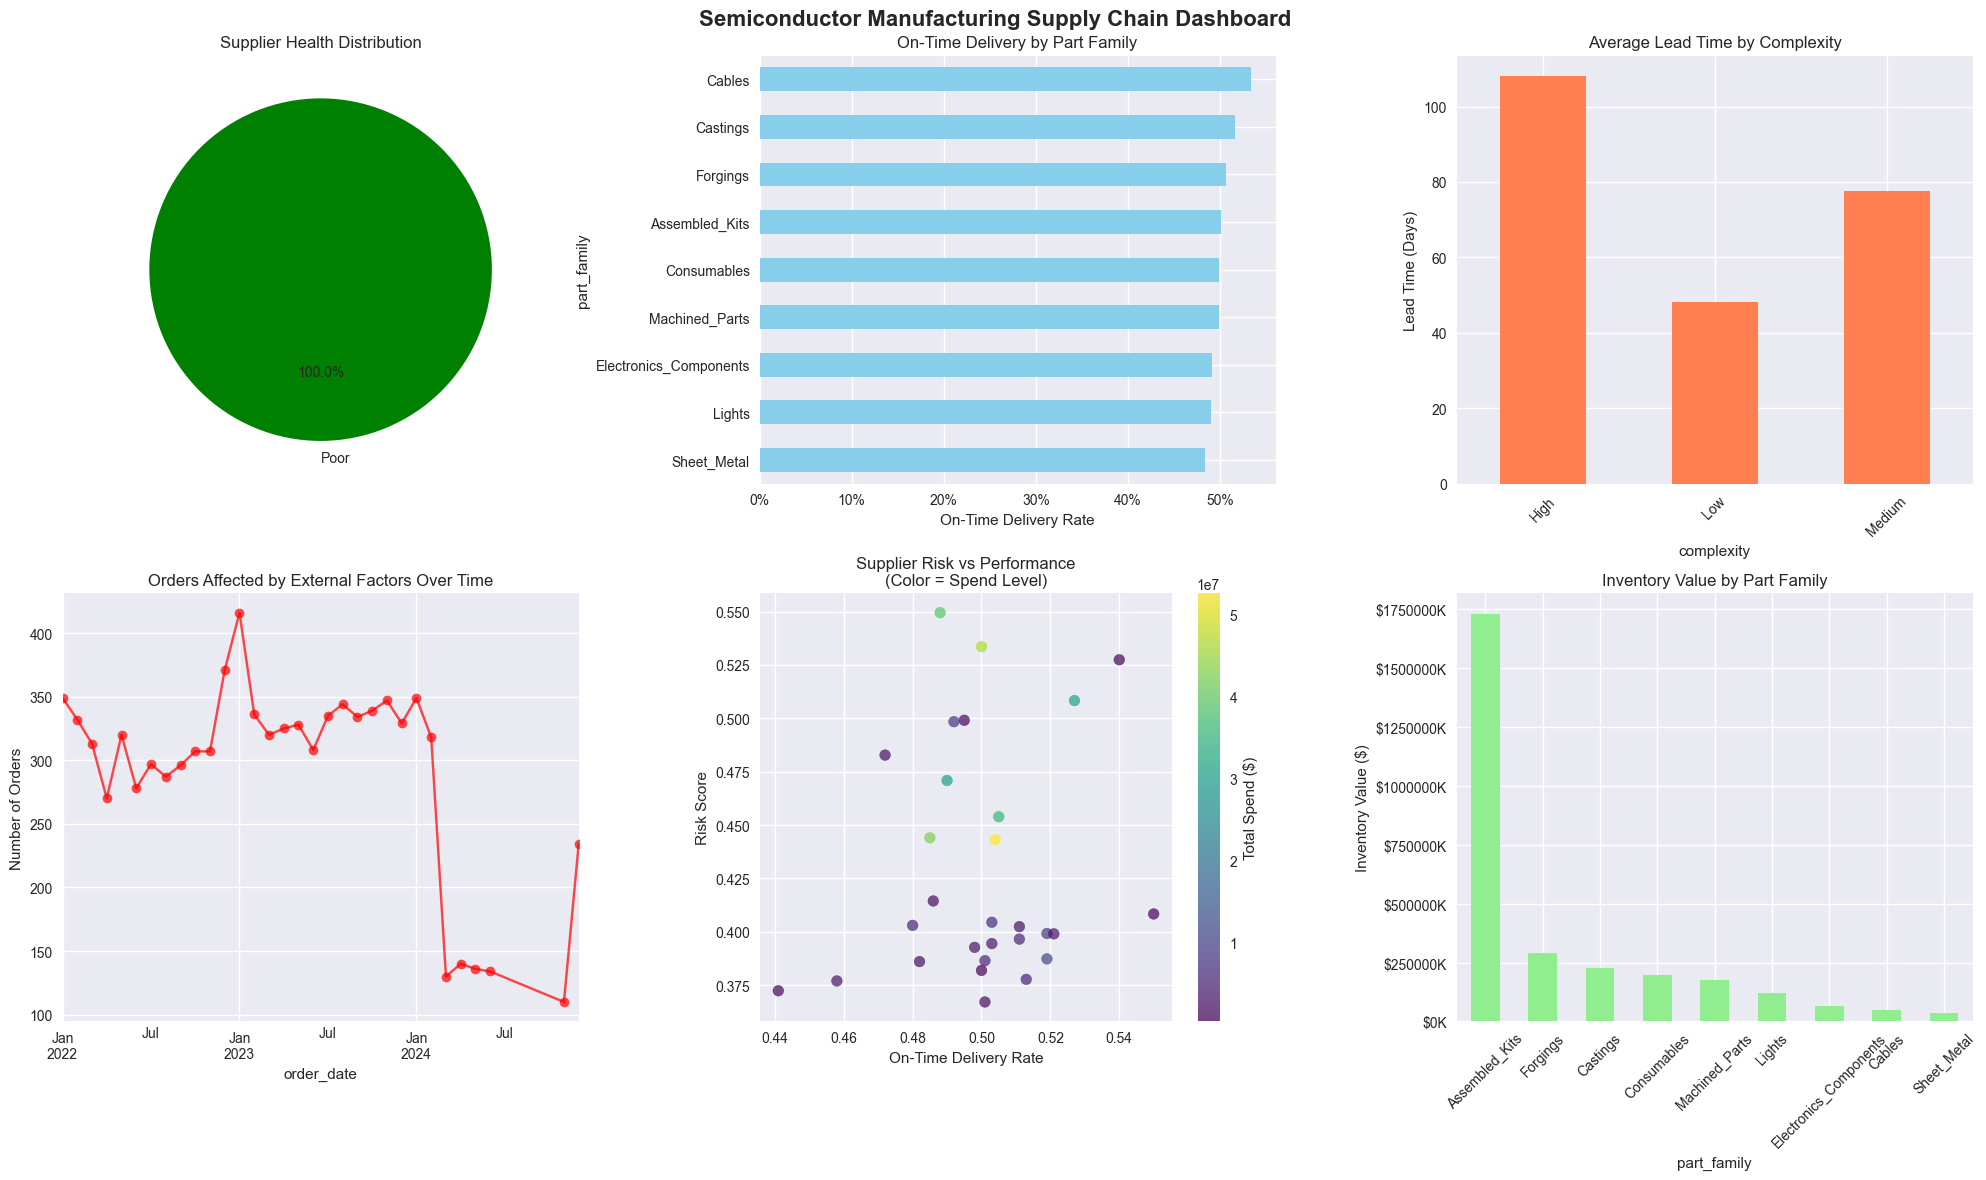

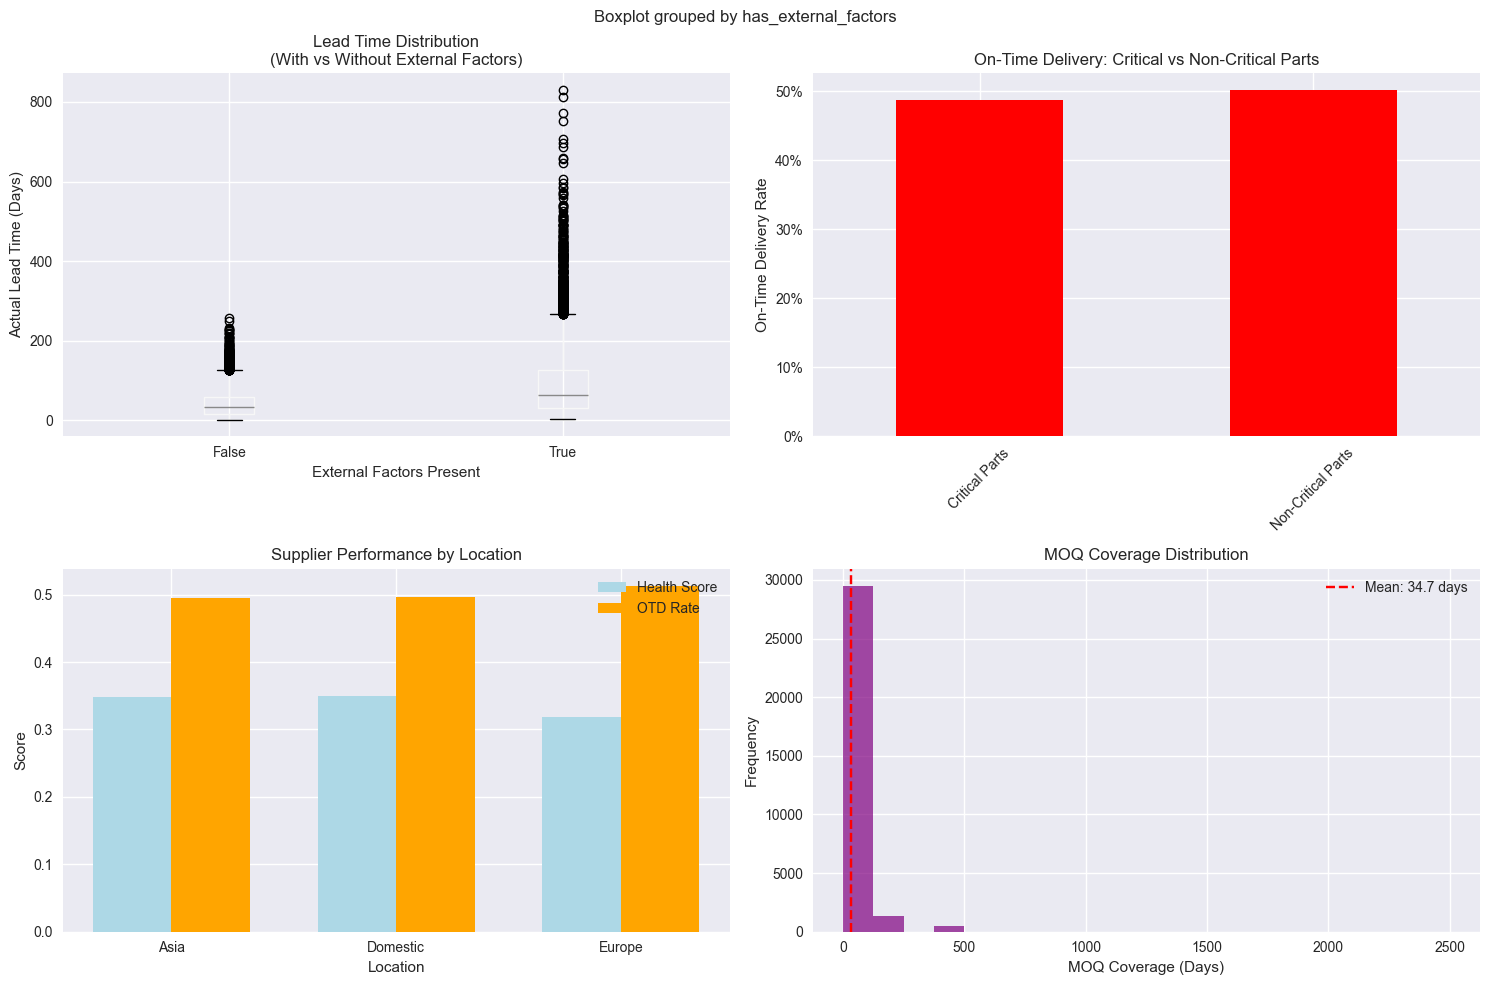

In [18]:
# Create comprehensive supplier and manufacturing performance dashboards

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Semiconductor Manufacturing Supply Chain Dashboard', fontsize=16, fontweight='bold')

# 1. Supplier Health Distribution
health_counts = supplier_health['Health_Category'].value_counts()
colors = ['green', 'orange', 'red', 'darkred']
axes[0,0].pie(health_counts.values, labels=health_counts.index, autopct='%1.1f%%', 
              colors=colors[:len(health_counts)], startangle=90)
axes[0,0].set_title('Supplier Health Distribution')

# 2. On-Time Delivery by Part Family
family_otd = po_df.groupby('part_family')['on_time_to_commit'].mean().sort_values(ascending=True)
family_otd.plot(kind='barh', ax=axes[0,1], color='skyblue')
axes[0,1].set_title('On-Time Delivery by Part Family')
axes[0,1].set_xlabel('On-Time Delivery Rate')
axes[0,1].xaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# 3. Lead Time vs Complexity
complexity_lt = po_df.groupby('complexity')['actual_lead_time'].mean()
complexity_lt.plot(kind='bar', ax=axes[0,2], color='coral')
axes[0,2].set_title('Average Lead Time by Complexity')
axes[0,2].set_ylabel('Lead Time (Days)')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. External Factors Impact
external_impact = po_df[po_df['external_factors'] != 'None']
if len(external_impact) > 0:
    impact_by_month = external_impact.groupby(external_impact['order_date'].dt.to_period('M')).size()
    impact_by_month.plot(ax=axes[1,0], marker='o', color='red', alpha=0.7)
    axes[1,0].set_title('Orders Affected by External Factors Over Time')
    axes[1,0].set_ylabel('Number of Orders')
else:
    axes[1,0].text(0.5, 0.5, 'No External\nFactors Data', ha='center', va='center', fontsize=12)
    axes[1,0].set_title('External Factors Impact')

# 5. Supplier Risk vs Performance
scatter_data = supplier_health.dropna(subset=['Actual_OTD', 'Risk_Score'])
if len(scatter_data) > 0:
    scatter = axes[1,1].scatter(scatter_data['Actual_OTD'], scatter_data['Risk_Score'], 
                               c=scatter_data['Total_Spend'], cmap='viridis', alpha=0.7, s=60)
    axes[1,1].set_xlabel('On-Time Delivery Rate')
    axes[1,1].set_ylabel('Risk Score')
    axes[1,1].set_title('Supplier Risk vs Performance\n(Color = Spend Level)')
    plt.colorbar(scatter, ax=axes[1,1], label='Total Spend ($)')
else:
    axes[1,1].text(0.5, 0.5, 'No Risk\nData Available', ha='center', va='center', fontsize=12)
    axes[1,1].set_title('Supplier Risk vs Performance')

# 6. Inventory Value by Part Family
family_inv_value = family_inventory_metrics['Total_Value'].sort_values(ascending=False)
family_inv_value.plot(kind='bar', ax=axes[1,2], color='lightgreen')
axes[1,2].set_title('Inventory Value by Part Family')
axes[1,2].set_ylabel('Inventory Value ($)')
axes[1,2].tick_params(axis='x', rotation=45)

# Format currency on y-axis
axes[1,2].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y/1000:.0f}K'))

plt.tight_layout()
plt.show()

# Additional analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Manufacturing Supply Chain Deep Dive', fontsize=16, fontweight='bold')

# 1. Lead Time Distribution by External Factors
if len(external_impact) > 0:
    po_df['has_external_factors'] = po_df['external_factors'] != 'None'
    po_df.boxplot(column='actual_lead_time', by='has_external_factors', ax=axes[0,0])
    axes[0,0].set_title('Lead Time Distribution\n(With vs Without External Factors)')
    axes[0,0].set_xlabel('External Factors Present')
    axes[0,0].set_ylabel('Actual Lead Time (Days)')
else:
    axes[0,0].hist(po_df['actual_lead_time'], bins=30, color='skyblue', alpha=0.7)
    axes[0,0].set_title('Lead Time Distribution')
    axes[0,0].set_xlabel('Actual Lead Time (Days)')

# 2. Critical Parts Performance
critical_po = po_df[po_df['critical_part'] == True]
non_critical_po = po_df[po_df['critical_part'] == False]

otd_comparison = pd.DataFrame({
    'Critical Parts': [critical_po['on_time_to_commit'].mean()],
    'Non-Critical Parts': [non_critical_po['on_time_to_commit'].mean()]
})

otd_comparison.T.plot(kind='bar', ax=axes[0,1], color=['red', 'blue'], legend=False)
axes[0,1].set_title('On-Time Delivery: Critical vs Non-Critical Parts')
axes[0,1].set_ylabel('On-Time Delivery Rate')
axes[0,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0,1].tick_params(axis='x', rotation=45)

# 3. Supplier Location Performance
if 'location' in supplier_health.columns:
    location_performance = supplier_health.groupby('location').agg({
        'Health_Score': 'mean',
        'Actual_OTD': 'mean'
    }).round(3)
    
    x = range(len(location_performance))
    width = 0.35
    
    axes[1,0].bar([i - width/2 for i in x], location_performance['Health_Score'], 
                  width, label='Health Score', color='lightblue')
    axes[1,0].bar([i + width/2 for i in x], location_performance['Actual_OTD'], 
                  width, label='OTD Rate', color='orange')
    
    axes[1,0].set_title('Supplier Performance by Location')
    axes[1,0].set_xlabel('Location')
    axes[1,0].set_ylabel('Score')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(location_performance.index)
    axes[1,0].legend()
else:
    axes[1,0].text(0.5, 0.5, 'No Location\nData Available', ha='center', va='center', fontsize=12)

# 4. MOQ Impact on Inventory
if not inventory_with_moq.empty and 'moq_coverage_days' in inventory_with_moq.columns:
    inventory_with_moq['moq_coverage_days'].hist(bins=20, ax=axes[1,1], color='purple', alpha=0.7)
    axes[1,1].axvline(inventory_with_moq['moq_coverage_days'].mean(), color='red', 
                      linestyle='--', label=f"Mean: {inventory_with_moq['moq_coverage_days'].mean():.1f} days")
    axes[1,1].set_title('MOQ Coverage Distribution')
    axes[1,1].set_xlabel('MOQ Coverage (Days)')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].legend()
else:
    axes[1,1].text(0.5, 0.5, 'No MOQ\nData Available', ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

### 4.2 Order Fulfillment Performance

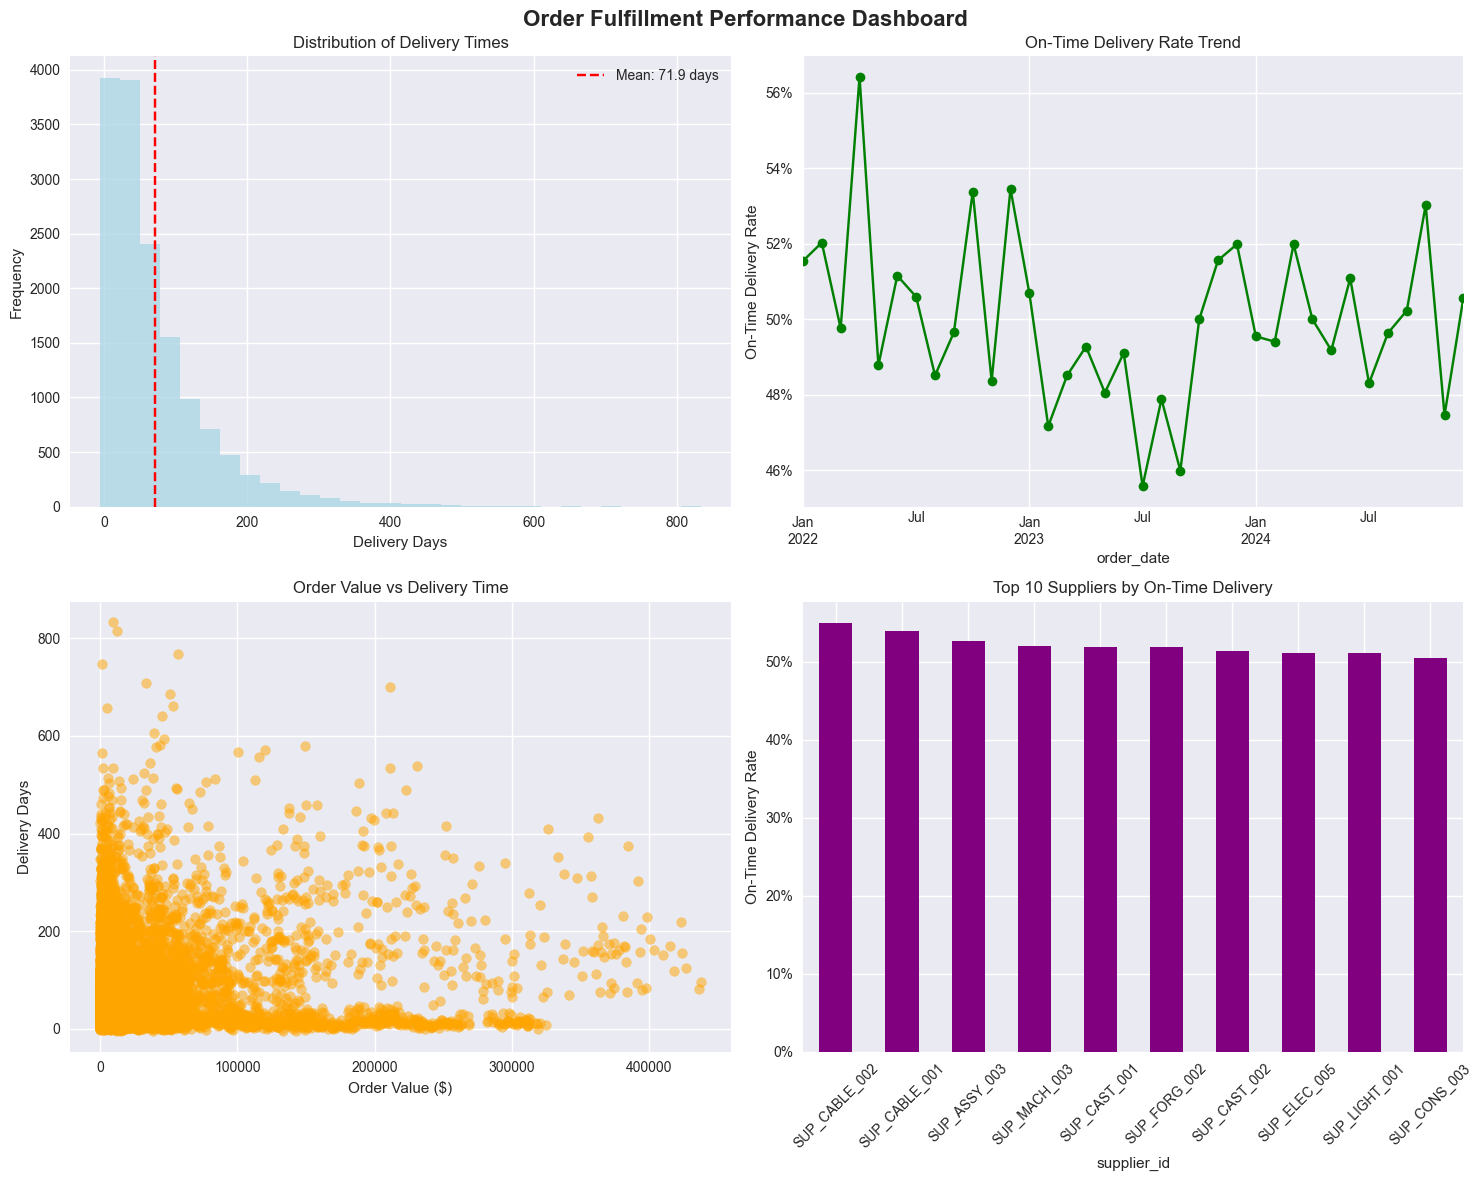

In [19]:
# Order fulfillment analysis using po_df data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Order Fulfillment Performance Dashboard', fontsize=16, fontweight='bold')

# Calculate delivery days from po_df
po_df['delivery_days'] = (po_df['actual_delivery_date'] - po_df['order_date']).dt.days

# 1. Delivery time distribution
po_df['delivery_days'].hist(bins=30, ax=axes[0,0], color='lightblue', alpha=0.8)
axes[0,0].axvline(po_df['delivery_days'].mean(), color='red', linestyle='--', 
                  label=f"Mean: {po_df['delivery_days'].mean():.1f} days")
axes[0,0].set_title('Distribution of Delivery Times')
axes[0,0].set_xlabel('Delivery Days')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 2. On-time delivery trend
monthly_otd = po_df.groupby(po_df['order_date'].dt.to_period('M'))['on_time_to_commit'].mean()
monthly_otd.plot(ax=axes[0,1], marker='o', color='green')
axes[0,1].set_title('On-Time Delivery Rate Trend')
axes[0,1].set_ylabel('On-Time Delivery Rate')
axes[0,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# 3. Order value vs delivery time
axes[1,0].scatter(po_df['total_value'], po_df['delivery_days'], alpha=0.5, color='orange')
axes[1,0].set_title('Order Value vs Delivery Time')
axes[1,0].set_xlabel('Order Value ($)')
axes[1,0].set_ylabel('Delivery Days')

# 4. Delivery performance by supplier
supplier_delivery = po_df.groupby('supplier_id')['on_time_to_commit'].mean().sort_values(ascending=False)
supplier_delivery.head(10).plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Top 10 Suppliers by On-Time Delivery')
axes[1,1].set_ylabel('On-Time Delivery Rate')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

### 4.3 Interactive Supplier Performance Dashboard

In [20]:
# Create interactive supplier performance dashboard using Plotly
# First create supplier_kpis from actual data

# Calculate supplier KPIs from existing data
supplier_kpis = supplier_health.copy()
supplier_kpis['overall_score'] = supplier_kpis['Health_Score']
supplier_kpis['delivery_performance'] = supplier_kpis['Actual_OTD'].fillna(supplier_kpis['base_otd_performance'])
supplier_kpis['quality_score'] = supplier_kpis['base_quality_score']
supplier_kpis['lead_time_days'] = supplier_kpis.get('Avg_Lead_Time', 30)  # Default if missing
supplier_kpis['cost_competitiveness'] = 1 - (supplier_kpis['Risk_Score'] * 0.3)  # Inverse of risk

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Supplier Overall Scores', 'Delivery Performance vs Quality', 
                   'Lead Time Analysis', 'Cost Competitiveness'),
    specs=[[{"type": "bar"}, {"type": "scatter"}],
           [{"type": "box"}, {"type": "bar"}]]
)

# 1. Supplier overall scores
top_10_suppliers = supplier_kpis.nlargest(10, 'overall_score')
fig.add_trace(
    go.Bar(x=top_10_suppliers['supplier_id'], y=top_10_suppliers['overall_score'],
           name='Overall Score', marker_color='lightblue'),
    row=1, col=1
)

# 2. Delivery vs Quality scatter plot
fig.add_trace(
    go.Scatter(x=supplier_kpis['delivery_performance'], y=supplier_kpis['quality_score'],
               mode='markers', text=supplier_kpis['supplier_id'],
               marker=dict(size=supplier_kpis['overall_score']*20, 
                          color=supplier_kpis['overall_score'],
                          colorscale='Viridis', showscale=True),
               name='Suppliers'),
    row=1, col=2
)

# 3. Lead time box plot
fig.add_trace(
    go.Box(y=supplier_kpis['lead_time_days'], name='Lead Time',
           marker_color='lightgreen'),
    row=2, col=1
)

# 4. Cost competitiveness
fig.add_trace(
    go.Bar(x=supplier_kpis['supplier_id'], y=supplier_kpis['cost_competitiveness'],
           name='Cost Competitiveness', marker_color='coral'),
    row=2, col=2
)

# Update layout
fig.update_layout(
    title_text="Supplier Performance Dashboard",
    title_x=0.5,
    height=800,
    showlegend=False
)

# Update axes labels
fig.update_xaxes(title_text="Delivery Performance", row=1, col=2)
fig.update_yaxes(title_text="Quality Score", row=1, col=2)
fig.update_yaxes(title_text="Lead Time (Days)", row=2, col=1)

fig.show()

## 5. Cost Analysis

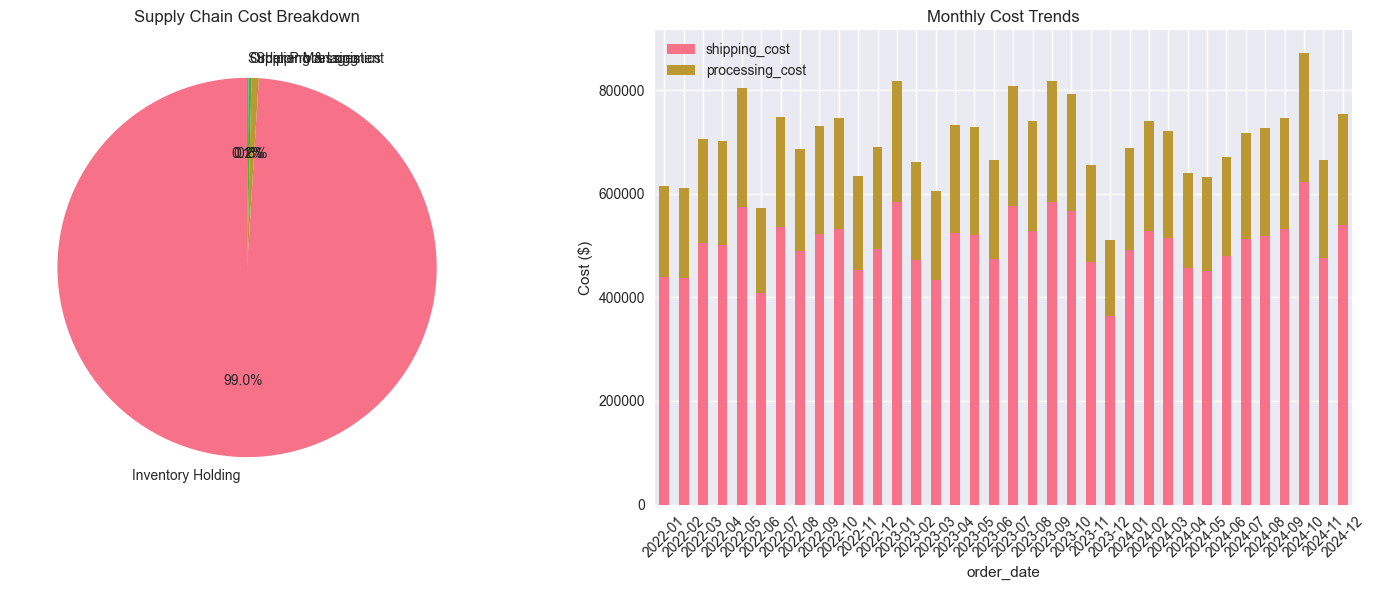

Total Supply Chain Costs: $2,920,516,383.57
Cost as % of Revenue: 806.23%

Cost Breakdown:
• Inventory Holding: $2,891,536,807 (99.0%)
• Shipping & Logistics: $18,112,235 (0.6%)
• Order Processing: $7,244,894 (0.2%)
• Supplier Management: $3,622,447 (0.1%)

Cost per Order: $194,701.09
Average Inventory Holding Cost per Part: $14,457,684.04


In [21]:
# Cost analysis using existing data
# Calculate total supply chain costs from available data
inventory_cost = inventory_sample['inventory_value'].sum()
total_order_value = po_df['total_value'].sum()

# Estimate shipping costs as percentage of order value
estimated_shipping_rate = 0.05  # 5% of order value
shipping_cost = total_order_value * estimated_shipping_rate

# Cost breakdown
cost_breakdown = {
    'Inventory Holding': inventory_cost,
    'Shipping & Logistics': shipping_cost,
    'Order Processing': total_order_value * 0.02,  # Assumed 2% of order value
    'Supplier Management': total_order_value * 0.01  # Assumed 1% of order value
}

# Create cost visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of cost breakdown
ax1.pie(cost_breakdown.values(), labels=cost_breakdown.keys(), autopct='%1.1f%%', startangle=90)
ax1.set_title('Supply Chain Cost Breakdown')

# Monthly cost trend using po_df data
monthly_costs = po_df.groupby(po_df['order_date'].dt.to_period('M')).agg({
    'total_value': 'sum'
})
monthly_costs['shipping_cost'] = monthly_costs['total_value'] * estimated_shipping_rate
monthly_costs['processing_cost'] = monthly_costs['total_value'] * 0.02

monthly_costs[['shipping_cost', 'processing_cost']].plot(kind='bar', stacked=True, ax=ax2)
ax2.set_title('Monthly Cost Trends')
ax2.set_ylabel('Cost ($)')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"Total Supply Chain Costs: ${sum(cost_breakdown.values()):,.2f}")
print(f"Cost as % of Revenue: {sum(cost_breakdown.values())/total_order_value:.2%}")

# Additional cost metrics
print(f"\nCost Breakdown:")
for category, cost in cost_breakdown.items():
    percentage = cost / sum(cost_breakdown.values()) * 100
    print(f"• {category}: ${cost:,.0f} ({percentage:.1f}%)")

print(f"\nCost per Order: ${sum(cost_breakdown.values())/len(po_df):,.2f}")
print(f"Average Inventory Holding Cost per Part: ${inventory_cost/inventory_sample['part_number'].nunique():,.2f}")

## 6. Executive Summary and Recommendations

In [22]:
# Generate semiconductor manufacturing executive summary
print("="*80)
print("SEMICONDUCTOR MANUFACTURING SUPPLY CHAIN EXECUTIVE SUMMARY")
print("="*80)

print("\n🎯 KEY PERFORMANCE INDICATORS:")
print(f"• Overall On-Time Delivery Rate: {po_metrics['on_time_delivery_rate']:.1%}")
print(f"• Average Lead Time: {po_metrics['avg_lead_time']:.1f} days")
print(f"• Lead Time Variability (StdDev): {po_metrics['lead_time_variance']:.1f} days")
print(f"• External Factors Impact: {po_metrics['external_factor_impact']:.1%} of orders affected")
print(f"• Total Supply Chain Spend: ${po_metrics['total_value']:,.0f}")
print(f"• Average Order Value: ${po_metrics['avg_order_value']:,.0f}")

print("\n🏥 SUPPLIER HEALTH OVERVIEW:")
health_summary = supplier_health['Health_Category'].value_counts()
total_suppliers = len(supplier_health)
for category in ['Excellent', 'Good', 'Fair', 'Poor']:
    if category in health_summary:
        count = health_summary[category]
        pct = count / total_suppliers * 100
        print(f"• {category}: {count} suppliers ({pct:.1f}%)")

avg_health = supplier_health['Health_Score'].mean()
print(f"• Average Supplier Health Score: {avg_health:.2f}/1.00")

print("\n📦 INVENTORY MANAGEMENT:")
total_inventory_value = family_inventory_metrics['Total_Value'].sum()
avg_days_inventory = inventory_sample['days_of_inventory'].mean()
stockout_risk_rate = inventory_sample['stockout_risk'].mean()

print(f"• Total Inventory Value: ${total_inventory_value:,.0f}")
print(f"• Average Days of Inventory: {avg_days_inventory:.1f} days")
print(f"• Inventory Turnover Rate: {365/avg_days_inventory:.1f}x annually")
print(f"• Parts at Stockout Risk: {stockout_risk_rate:.1%}")

# Critical parts analysis
critical_otd = po_df[po_df['critical_part'] == True]['on_time_to_commit'].mean()
print(f"• Critical Parts OTD Rate: {critical_otd:.1%}")

print("\n🔧 PART FAMILY PERFORMANCE:")
print("Top 3 part families by reliability (OTD):")
top_families_otd = family_performance.nlargest(3, 'OTD_Rate')[['OTD_Rate', 'Order_Count']]
for family, row in top_families_otd.iterrows():
    print(f"   • {family}: {row['OTD_Rate']:.1%} OTD ({row['Order_Count']} orders)")

print("\nPart families requiring attention (lowest OTD):")
bottom_families_otd = family_performance.nsmallest(2, 'OTD_Rate')[['OTD_Rate', 'Total_Value']]
for family, row in bottom_families_otd.iterrows():
    print(f"   • {family}: {row['OTD_Rate']:.1%} OTD (${row['Total_Value']:,.0f} spend)")

print("\n🌍 EXTERNAL RISK FACTORS:")
if len(external_factors_impact) > 0:
    print("Most impactful external factors:")
    for factor, count in external_factors_impact.head(3).items():
        pct = count / len(po_df) * 100
        print(f"   • {factor}: {count} orders affected ({pct:.1f}%)")
else:
    print("   • No significant external factor impacts detected")

print("\n⚠️ CRITICAL RISKS IDENTIFIED:")
risk_items = []

# Supplier risks
poor_health_suppliers = len(supplier_health[supplier_health['Health_Category'].isin(['Poor', 'Fair'])])
if poor_health_suppliers > 0:
    risk_items.append(f"• {poor_health_suppliers} suppliers with poor/fair health ratings")

# Single source risks
single_source_count = len(supplier_health[supplier_health['single_source_risk'] == True])
if single_source_count > 0:
    risk_items.append(f"• {single_source_count} single-source suppliers")

# Critical parts risks
if critical_otd < 0.95:
    risk_items.append(f"• Critical parts OTD below 95% target ({critical_otd:.1%})")

# Inventory risks
high_stockout_families = family_inventory_metrics[family_inventory_metrics['Stockout_Risk_Rate'] > 0.1]
if len(high_stockout_families) > 0:
    risk_items.append(f"• {len(high_stockout_families)} part families with high stockout risk")

# Lead time variability
if po_metrics['lead_time_variance'] > 15:
    risk_items.append(f"• High lead time variability ({po_metrics['lead_time_variance']:.1f} days std dev)")

if risk_items:
    for risk in risk_items:
        print(risk)
else:
    print("   • No critical risks above threshold levels identified")

print("\n💡 STRATEGIC RECOMMENDATIONS:")

recommendations = []

# Supplier-focused recommendations
if poor_health_suppliers > 0:
    recommendations.append("1. Implement supplier improvement programs for poor/fair rated suppliers")
    recommendations.append("2. Develop backup suppliers for critical single-source parts")

# Performance-focused recommendations
if po_metrics['on_time_delivery_rate'] < 0.95:
    recommendations.append("3. Focus on improving OTD for underperforming part families")

# Inventory-focused recommendations
if stockout_risk_rate > 0.05:
    recommendations.append("4. Optimize safety stock levels for critical and high-risk parts")

# External factors recommendations
if po_metrics['external_factor_impact'] > 0.3:
    recommendations.append("5. Develop contingency plans for high-impact external factors")

# MOQ optimization
if not inventory_with_moq.empty:
    recommendations.append("6. Review MOQ agreements to balance inventory holding costs")

# General recommendations
recommendations.extend([
    "7. Implement real-time supplier performance monitoring",
    "8. Establish supplier diversification program for critical components",
    "9. Negotiate better terms with high-performing suppliers",
    "10. Develop predictive analytics for demand forecasting"
])

for rec in recommendations[:8]:  # Limit to top 8 recommendations
    print(rec)

print("\n📊 BUSINESS IMPACT:")
total_orders = len(po_df)
late_orders = len(po_df[po_df['on_time_to_commit'] == False])
potential_savings = total_inventory_value * 0.1  # Assume 10% optimization potential

print(f"• {late_orders:,} late deliveries out of {total_orders:,} total orders")
print(f"• Potential inventory optimization savings: ${potential_savings:,.0f}")
print(f"• External factors affected {(po_metrics['external_factor_impact'] * total_orders):,.0f} orders")

print("\n" + "="*80)

SEMICONDUCTOR MANUFACTURING SUPPLY CHAIN EXECUTIVE SUMMARY

🎯 KEY PERFORMANCE INDICATORS:
• Overall On-Time Delivery Rate: 50.0%
• Average Lead Time: 72.4 days
• Lead Time Variability (StdDev): 75.4 days
• External Factors Impact: 62.3% of orders affected
• Total Supply Chain Spend: $362,244,706
• Average Order Value: $24,150

🏥 SUPPLIER HEALTH OVERVIEW:
• Poor: 29 suppliers (100.0%)
• Average Supplier Health Score: 0.34/1.00

📦 INVENTORY MANAGEMENT:
• Total Inventory Value: $2,891,536,807
• Average Days of Inventory: 188.3 days
• Inventory Turnover Rate: 1.9x annually
• Parts at Stockout Risk: 19.0%
• Critical Parts OTD Rate: 48.8%

🔧 PART FAMILY PERFORMANCE:
Top 3 part families by reliability (OTD):
   • Cables: 53.4% OTD (1113.0 orders)
   • Castings: 51.7% OTD (1055.0 orders)
   • Forgings: 50.7% OTD (1072.0 orders)

Part families requiring attention (lowest OTD):
   • Sheet_Metal: 48.3% OTD ($4,864,845 spend)
   • Lights: 49.0% OTD ($6,809,885 spend)

🌍 EXTERNAL RISK FACTORS:
Most

## 7. Data Export and Reporting

In [23]:
# Export comprehensive semiconductor manufacturing supply chain reports

# 1. Executive KPI Summary
executive_summary = pd.DataFrame({
    'Metric': [
        'On-Time Delivery Rate', 'Average Lead Time (Days)', 'Lead Time Variability (Days)',
        'External Factors Impact Rate', 'Total Supply Chain Spend ($M)', 
        'Average Supplier Health Score', 'Critical Parts OTD Rate',
        'Inventory Turnover (Annual)', 'Parts at Stockout Risk Rate'
    ],
    'Value': [
        po_metrics['on_time_delivery_rate'],
        po_metrics['avg_lead_time'],
        po_metrics['lead_time_variance'],
        po_metrics['external_factor_impact'],
        po_metrics['total_value'] / 1_000_000,
        supplier_health['Health_Score'].mean(),
        po_df[po_df['critical_part'] == True]['on_time_to_commit'].mean(),
        365 / inventory_sample['days_of_inventory'].mean(),
        inventory_sample['stockout_risk'].mean()
    ],
    'Target': [0.95, 30, 10, 0.20, None, 0.85, 0.98, 6.0, 0.05],
    'Status': [
        '✓' if po_metrics['on_time_delivery_rate'] >= 0.95 else '⚠',
        '✓' if po_metrics['avg_lead_time'] <= 30 else '⚠',
        '✓' if po_metrics['lead_time_variance'] <= 10 else '⚠',
        '✓' if po_metrics['external_factor_impact'] <= 0.20 else '⚠',
        'N/A',
        '✓' if supplier_health['Health_Score'].mean() >= 0.85 else '⚠',
        '✓' if po_df[po_df['critical_part'] == True]['on_time_to_commit'].mean() >= 0.98 else '⚠',
        '✓' if 365 / inventory_sample['days_of_inventory'].mean() >= 6.0 else '⚠',
        '✓' if inventory_sample['stockout_risk'].mean() <= 0.05 else '⚠'
    ]
})

# 2. Supplier Health Report
supplier_health_export = supplier_health[[
    'supplier_id', 'supplier_type', 'location', 'Health_Score', 'Health_Category',
    'Actual_OTD', 'Total_Spend', 'Risk_Score', 'financial_rating',
    'single_source_risk', 'backup_supplier_available'
]].round(3)

# 3. Part Family Performance Report
family_performance_export = family_performance.copy()
family_performance_export.index.name = 'Part_Family'
family_performance_export = family_performance_export.reset_index()

# 4. Purchase Order Analysis
po_export = po_df[[
    'po_number', 'order_date', 'part_number', 'part_family', 'complexity',
    'supplier_id', 'quantity_ordered', 'total_value', 'nominal_lead_time',
    'actual_lead_time', 'on_time_to_commit', 'external_factors', 'critical_part'
]].copy()

# 5. Inventory Analysis by Family
inventory_export = family_inventory_metrics.copy()
inventory_export.index.name = 'Part_Family'
inventory_export = inventory_export.reset_index()

# 6. Critical Parts Analysis
critical_parts_analysis = po_df[po_df['critical_part'] == True].groupby('part_family').agg({
    'on_time_to_commit': 'mean',
    'actual_lead_time': 'mean',
    'total_value': 'sum',
    'po_number': 'count'
}).round(3)
critical_parts_analysis.columns = ['Critical_OTD_Rate', 'Avg_Lead_Time', 'Total_Spend', 'Order_Count']
critical_parts_analysis.index.name = 'Part_Family'
critical_parts_analysis = critical_parts_analysis.reset_index()

# 7. External Factors Impact Report
if len(external_factors_impact) > 0:
    external_impact_export = pd.DataFrame({
        'External_Factor': external_factors_impact.index,
        'Orders_Affected': external_factors_impact.values,
        'Impact_Percentage': (external_factors_impact.values / len(po_df) * 100).round(2)
    })
else:
    external_impact_export = pd.DataFrame(columns=['External_Factor', 'Orders_Affected', 'Impact_Percentage'])

# 8. Risk Assessment Report
risk_suppliers = supplier_health[supplier_health['Risk_Score'] > 0.3][
    ['supplier_id', 'Health_Score', 'Risk_Score', 'Total_Spend', 'single_source_risk']
].sort_values('Risk_Score', ascending=False)

# Save all reports to CSV
try:
    executive_summary.to_csv('semiconductor_executive_summary.csv', index=False)
    supplier_health_export.to_csv('supplier_health_scorecard.csv', index=False)
    family_performance_export.to_csv('part_family_performance.csv', index=False)
    po_export.to_csv('purchase_order_analysis.csv', index=False)
    inventory_export.to_csv('inventory_analysis_by_family.csv', index=False)
    critical_parts_analysis.to_csv('critical_parts_analysis.csv', index=False)
    external_impact_export.to_csv('external_factors_impact.csv', index=False)
    risk_suppliers.to_csv('high_risk_suppliers.csv', index=False)
    
    # Save parts catalog and supplier profiles
    parts_df.to_csv('parts_catalog.csv', index=False)
    supplier_profiles_df.to_csv('supplier_profiles.csv', index=False)
    
    print("📁 SEMICONDUCTOR MANUFACTURING REPORTS EXPORTED:")
    print("=" * 60)
    print("📊 Executive & Summary Reports:")
    print("   • semiconductor_executive_summary.csv")
    print("   • part_family_performance.csv")
    print("   • critical_parts_analysis.csv")
    print("")
    print("🏥 Supplier Analysis Reports:")
    print("   • supplier_health_scorecard.csv")
    print("   • high_risk_suppliers.csv")
    print("   • supplier_profiles.csv")
    print("")
    print("📦 Operational Reports:")
    print("   • purchase_order_analysis.csv")
    print("   • inventory_analysis_by_family.csv")
    print("   • external_factors_impact.csv")
    print("   • parts_catalog.csv")
    
except Exception as e:
    print(f"Error saving files: {e}")

# Display key summary tables
print(f"\n📋 EXECUTIVE KPI SUMMARY:")
print(executive_summary.to_string(index=False, float_format='%.3f'))

print(f"\n🏆 TOP 5 SUPPLIERS BY HEALTH SCORE:")
top_suppliers_display = supplier_health_export.nlargest(5, 'Health_Score')[
    ['supplier_id', 'supplier_type', 'Health_Score', 'Actual_OTD', 'Total_Spend']
]
print(top_suppliers_display.to_string(index=False))

print(f"\n⚠️ HIGH RISK SUPPLIERS (Risk Score > 0.3):")
if len(risk_suppliers) > 0:
    print(risk_suppliers.head().to_string(index=False))
else:
    print("   No high-risk suppliers identified")

print(f"\n🔧 PART FAMILY PERFORMANCE SUMMARY:")
print(family_performance_export[['Part_Family', 'OTD_Rate', 'Order_Count', 'Total_Value']].to_string(index=False))

print(f"\n📦 INVENTORY VALUE BY FAMILY:")
inventory_value_summary = inventory_export[['Part_Family', 'Total_Value', 'Stockout_Risk_Rate']].sort_values('Total_Value', ascending=False)
print(inventory_value_summary.to_string(index=False))

📁 SEMICONDUCTOR MANUFACTURING REPORTS EXPORTED:
📊 Executive & Summary Reports:
   • semiconductor_executive_summary.csv
   • part_family_performance.csv
   • critical_parts_analysis.csv

🏥 Supplier Analysis Reports:
   • supplier_health_scorecard.csv
   • high_risk_suppliers.csv
   • supplier_profiles.csv

📦 Operational Reports:
   • purchase_order_analysis.csv
   • inventory_analysis_by_family.csv
   • external_factors_impact.csv
   • parts_catalog.csv

📋 EXECUTIVE KPI SUMMARY:
                       Metric   Value  Target Status
        On-Time Delivery Rate   0.500   0.950      ⚠
     Average Lead Time (Days)  72.378  30.000      ⚠
 Lead Time Variability (Days)  75.427  10.000      ⚠
 External Factors Impact Rate   0.623   0.200      ⚠
Total Supply Chain Spend ($M) 362.245     NaN    N/A
Average Supplier Health Score   0.341   0.850      ⚠
      Critical Parts OTD Rate   0.488   0.980      ⚠
  Inventory Turnover (Annual)   1.939   6.000      ⚠
  Parts at Stockout Risk Rate   0.190  